In [2]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [3]:
import tensorflow as tf

# Creating and running graph

In [3]:
reset_graph()

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2


In [4]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [5]:
x

<tf.Variable 'x:0' shape=() dtype=int32_ref>

In [6]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [7]:
sess.close()

In [8]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result=f.eval()

In [9]:
result

42

# Managing graphs

In [10]:
reset_graph()

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [11]:
x1.graph

In [12]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

In [13]:
x2.graph

In [14]:
tf.get_default_graph()

In [15]:
# x and w calculated twice (for z and y)
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


In [16]:
# x and w calculated once
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# Linear Regression with tf

In [17]:

import numpy as np
from sklearn.datasets import fetch_california_housing



In [18]:
reset_graph()

In [19]:
housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

In [20]:
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT,X)), XT),y)


In [21]:
with tf.Session() as sess:
    theta_value = theta.eval()

In [22]:
theta_value

array([[-3.7225266e+01],
       [ 4.3568176e-01],
       [ 9.3872147e-03],
       [-1.0598953e-01],
       [ 6.3939309e-01],
       [-4.1104349e-06],
       [-3.7780963e-03],
       [-4.2437303e-01],
       [-4.3785891e-01]], dtype=float32)

In [23]:


X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


In [25]:
len(housing.data)

20640

# Using Batch Gradient Descent

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((len(housing.data),1)), scaled_housing_data]

In [27]:

print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


In [28]:
housing.target.shape

(20640,)

In [29]:
housing.target.reshape(-1, 1).shape

(20640, 1)

## Manual gradients computing

In [30]:
reset_graph()

#Construction phase
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y= tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1,1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate*gradients)

init = tf.global_variables_initializer()

In [31]:
#Execusion phase

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 ==0:
            print("Epoch", epoch, "MSE=", mse.eval())
        sess.run(training_op)
    
    best_theta=theta.eval()

Epoch 0 MSE= 9.161542
Epoch 100 MSE= 0.71450055
Epoch 200 MSE= 0.56670487
Epoch 300 MSE= 0.55557173
Epoch 400 MSE= 0.5488112
Epoch 500 MSE= 0.5436363
Epoch 600 MSE= 0.53962904
Epoch 700 MSE= 0.5365092
Epoch 800 MSE= 0.53406775
Epoch 900 MSE= 0.5321473


In [32]:
best_theta

array([[ 2.0685523 ],
       [ 0.8874027 ],
       [ 0.14401656],
       [-0.34770885],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145283],
       [-0.6375278 ]], dtype=float32)

## Using autodiff

In [33]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [34]:

gradients = tf.gradients(mse, [theta])[0]

In [35]:
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.7145004
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962904
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


## Gradient Optimizer

In [36]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [37]:

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

In [38]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.7145004
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962904
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


## Momentum Optimizer

In [39]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [40]:

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)
training_op = optimizer.minimize(mse)


In [41]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.53056407
Epoch 200 MSE = 0.52501124
Epoch 300 MSE = 0.52441067
Epoch 400 MSE = 0.52433294
Epoch 500 MSE = 0.5243226
Epoch 600 MSE = 0.5243211
Epoch 700 MSE = 0.524321
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321
Best theta:
[[ 2.068558  ]
 [ 0.8296286 ]
 [ 0.11875337]
 [-0.26554456]
 [ 0.3057109 ]
 [-0.00450251]
 [-0.03932662]
 [-0.89986444]
 [-0.87052065]]


# Feeding data to the training algorithm

## Placeholder nodes

In [49]:
reset_graph()

A = tf.placeholder(tf.float32, shape = (None,3))
B = A+5

with tf.Session() as sess:
    B_val_1=B.eval(feed_dict = {A:[[1,2,3]]})
    B_val_2=B.eval(feed_dict = {A: [[4, 5, 6], [7, 8, 9]]})
    
print(B_val_1)
print(B_val_2)

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


## Mini-batch Gradient Descent

In [90]:

n_epochs = 1000
learning_rate = 0.01

In [91]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

In [92]:
theta = tf.Variable(tf.random_uniform([n+1,1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [93]:
n_epochs = 10

In [94]:
batch_size=100
n_batches = int(np.ceil(m/batch_size))

In [95]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1,1)[indices]
    return X_batch, y_batch

In [103]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
     
    best_theta = theta.eval()

In [97]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

# Saving and restoring a model

In [109]:
reset_graph()

n_epochs = 1000                                                                       # not shown in the book
learning_rate = 0.01                                                                  # not shown

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            # not shown
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            # not shown
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      # not shown
error = y_pred - y                                                                    # not shown
mse = tf.reduce_mean(tf.square(error), name="mse")                                    # not shown
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            # not shown
training_op = optimizer.minimize(mse)                                                 # not shown

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                                # not shown
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.7145004
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962904
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473


In [110]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

In [111]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval() # not shown in the book

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [114]:
best_theta_restored

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

In [115]:
saver = tf.train.Saver({"weights": theta})

In [116]:

reset_graph()
# notice that we start with an empty graph.

saver = tf.train.import_meta_graph("/tmp/my_model_final.ckpt.meta")  # this loads the graph structure
theta = tf.get_default_graph().get_tensor_by_name("theta:0") # not shown in the book

with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")  # this restores the graph's state
    best_theta_restored = theta.eval() # not shown in the book

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


# Visualizaing the graph

In [117]:
from datetime import datetime

In [130]:

reset_graph()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [131]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [132]:

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [133]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [134]:
with tf.Session() as sess:                                                        # not shown in the book
    sess.run(init)                                                                # not shown

    for epoch in range(n_epochs):                                                 # not shown
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()       

In [135]:

file_writer.close()

In CMD:

cd $Path
Python
import tensorflow as tf
exit()

tensorboard --logdir=tf_logs

In [136]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

# Naming Scopes

In [137]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [138]:
with tf.name_scope("loss") as scope:
    error = y_pred -y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [139]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [140]:

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


In [141]:

print(error.op.name)

loss/sub


# Modularity

In [146]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]),1)
        w=tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z=tf.add(tf.matmul(X,w), b, name="z")
        return tf.maximum(z,0., name="max")

In [147]:
n_features = 3
X=tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus=[relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("tf_logs/relu", tf.get_default_graph())
file_writer.close()

# Sharing Variables

In [148]:
reset_graph()

with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

In [149]:

with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")

In [150]:
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

In [151]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

In [152]:
file_writer = tf.summary.FileWriter("tf_logs/relu2", tf.get_default_graph())
file_writer.close()

In [153]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
    b = tf.Variable(0.0, name="bias")                           # not shown
    z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [154]:
file_writer = tf.summary.FileWriter("tf_logs/relu3", tf.get_default_graph())
file_writer.close()

## Handling Scopes and Names

In [4]:
reset_graph()

with tf.variable_scope("my_scope"):
    x0 = tf.get_variable("x",shape=(), initializer=tf.constant_initializer(0.))
    x1=tf.Variable(0.,name="x")
    x2=tf.Variable(0.,name="x")
    
print("x0:", x0.op.name)
print("x1:", x1.op.name)
print("x2:", x2.op.name)

    

x0: my_scope/x
x1: my_scope/x_1
x2: my_scope/x_2


In [5]:
with tf.variable_scope("my_scope", reuse=True):
    x3 = tf.get_variable("x")
    x4 = tf.Variable(0., name="x")
    
# As x3 resuses variable initialized in first use of my_scope it is within the first scope,
# while x4 is a new initialized within a new scope which is renamed as my_scope_1

In [6]:
print("x3:", x3.op.name)
print("x4:", x4.op.name)

x3: my_scope/x
x4: my_scope_1/x


In [7]:
with tf.variable_scope("", default_name="", reuse=True):
    x5 = tf.get_variable("my_scope/x")

In [8]:
print("x5:", x5.op.name)

x5: my_scope/x


## Strings

In [12]:
reset_graph()

text = np.array("Do you want some cafe".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
    print(text_tensor.eval())

[b'Do' b'you' b'want' b'some' b'cafe']


# Logistic Regression with Mini-Batch Gradient Descent using TensorFlow

In [13]:

from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

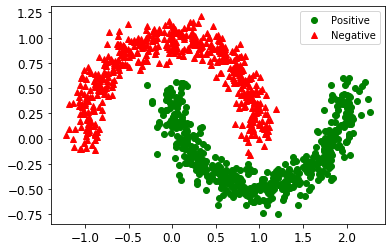

In [14]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [17]:
X_moons_with_bias = np.c_[np.ones((m,1)), X_moons]

In [20]:
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [22]:
y_moons.shape

(1000,)

In [25]:
y_moons_vector=y_moons.reshape(-1,1)
y_moons_vector.shape

(1000, 1)

In [26]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_vector[:-test_size]
y_test = y_moons_vector[-test_size:]

In [27]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [31]:
X_batch, y_batch = random_batch(X_train, y_train, 10)
X_batch

array([[ 1.        , -0.04027286,  0.15633953],
       [ 1.        ,  0.73249294, -0.40782775],
       [ 1.        , -0.7805163 ,  0.4411743 ],
       [ 1.        ,  0.60832246,  0.54703694],
       [ 1.        ,  0.68675984, -0.37776263],
       [ 1.        ,  0.79170038, -0.51349765],
       [ 1.        , -0.77267555,  0.75156907],
       [ 1.        ,  0.71607055, -0.51694196],
       [ 1.        ,  0.59758054,  0.81803294],
       [ 1.        ,  1.59735283, -0.47462025]])

In [33]:
X_train.shape[1]

3

In [84]:
reset_graph()

n_features=X_train.shape[1]

In [85]:
X=tf.placeholder(tf.float32, shape=(None, n_features), name="X")
y=tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_features,1],-1.0,1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba=tf.sigmoid(logits)
loss = tf.losses.log_loss(y, y_proba)

learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)


init = tf.global_variables_initializer()


In [86]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.79260236
Epoch: 100 	Loss: 0.34346348
Epoch: 200 	Loss: 0.3075404
Epoch: 300 	Loss: 0.29288894
Epoch: 400 	Loss: 0.28533572
Epoch: 500 	Loss: 0.28047803
Epoch: 600 	Loss: 0.27808294
Epoch: 700 	Loss: 0.27615443
Epoch: 800 	Loss: 0.27551997
Epoch: 900 	Loss: 0.27491233


In [87]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [88]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.8627450980392157

In [89]:
recall_score(y_test, y_pred)

0.8888888888888888

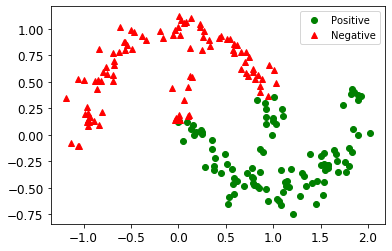

In [90]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [91]:
from sklearn.preprocessing import PolynomialFeatures
poly_features=PolynomialFeatures(2)


In [121]:
poly_features=PolynomialFeatures(3)

In [122]:
X_train_enhanced=poly_features.fit_transform(X_train)

In [123]:
X_test_enhanced=poly_features.fit_transform(X_test)

In [124]:
reset_graph()

In [125]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias=int(X.shape[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1],-1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope = "loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary=tf.summary.scalar("log_loss", loss)
        with tf.name_scope("init"):
            init=tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
        return y_proba, loss, training_op, loss_summary, init, saver

In [126]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [127]:

n_inputs = X_train_enhanced.shape[1]
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [128]:

n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.4587807
Epoch: 500 	Loss: 0.12309103
Epoch: 1000 	Loss: 0.08659261
Epoch: 1500 	Loss: 0.06989695
Epoch: 2000 	Loss: 0.059857417
Epoch: 2500 	Loss: 0.053269304
Epoch: 3000 	Loss: 0.04836173
Epoch: 3500 	Loss: 0.044795908
Epoch: 4000 	Loss: 0.041822463
Epoch: 4500 	Loss: 0.03932313
Epoch: 5000 	Loss: 0.03740792
Epoch: 5500 	Loss: 0.035666384
Epoch: 6000 	Loss: 0.034333933
Epoch: 6500 	Loss: 0.03310109
Epoch: 7000 	Loss: 0.031992022
Epoch: 7500 	Loss: 0.030946078
Epoch: 8000 	Loss: 0.03002555
Epoch: 8500 	Loss: 0.029278046
Epoch: 9000 	Loss: 0.028543754
Epoch: 9500 	Loss: 0.027903758
Epoch: 10000 	Loss: 0.027305938


In [129]:
y_pred = (y_proba_val >= 0.5)

In [130]:
precision_score(y_test, y_pred)

0.9797979797979798

In [131]:
recall_score(y_test, y_pred)

0.9797979797979798

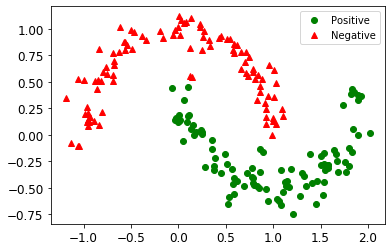

In [132]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

# Randomized Grid-Search for best parameters

In [135]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)
    n_inputs = X_train_enhanced.shape[1]
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

Iteration 0
  logdir: tf_logs/logreg-run-20190923193103/
  batch size: 87
  learning_rate: 0.004430375245218265
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 1
  logdir: tf_logs/logreg-run-20190923193141/
  batch size: 61
  learning_rate: 0.0017826497151386947
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 2
  logdir: tf_logs/logreg-run-20190923193230/
  batch size: 92
  learning_rate: 0.00203228544324115
  training: .....................
  precision: 0.97
  recall: 0.9797979797979798
Iteration 3
  logdir: tf_logs/logreg-run-20190923193304/
  batch size: 74
  learning_rate: 0.004491523825137997
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 4
  logdir: tf_logs/logreg-run-20190923193346/
  batch size: 58
  learning_rate: 0.07963234721775589
  training: .....................
  precision: 0.9801980198019802
  recall: